In [255]:
import pandas as pd #
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math #
from sklearn import preprocessing #

import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc, precision_score, accuracy_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV #
from sklearn.model_selection import train_test_split #
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score #
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold #
from sklearn.model_selection import cross_validate #

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder #

from sklearn.ensemble import RandomForestClassifier as RFC#
import xgboost
from xgboost import XGBClassifier
from scipy import interp

import shap
from shap import TreeExplainer
from category_encoders import *
import pickle
from pickle import load
from time import sleep
from tqdm.notebook import tqdm
import joblib
from joblib import load as jload
from collections import Counter
import seaborn as sns
import time
# some notebook settings
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(precision=4, suppress=True, linewidth=110)

# pd.set_option('display.max_columns', 1000)  # or 1000
# pd.set_option('display.max_rows', 2000)  # or 1000
pd.set_option('display.max_colwidth', None)
sns.set_theme()

In [ ]:
#idea is to first get correlations between features
#then compare SHAP feature importance between train and test set
#check out SHAP interaction values
#Check if there are correlated features with interactions, that might have high importance on the train but low on the test -> remove?

In [276]:
print(os.getcwd())
data = jload('../data/unfolded_df-23_03_2023.pkl')
undummied_data = pd.read_csv('../data/DMF_for_networks_and_undummied.csv')
results = jload('../data/results_df-2023_03_23.pkl')
model=joblib.load('../models/deployment_clf-28_03_2023.pkl')
print('LOADED!')

/data/victorciulei/my_stuff/GS_Zee/notebooks
LOADED!


In [310]:
data_target = data.target.copy()
#data.drop(['container_time_id','target'],axis=1,inplace=True)
data.columns.tolist()

AttributeError: 'DataFrame' object has no attribute 'target'

In [312]:
data.head()

,CLASS1_PGhighest_perc_change_last_month,CLASS1_PGhighest_perc_change_last_month_shouldbeNA,CLASS1_PGhighest_perc_change_last_prev_12months,CLASS1_PGhighest_perc_change_last_prev_12months_shouldbeNA,CLASS1_PGhighest_perc_change_months_year_ago,CLASS1_PGhighest_perc_change_months_year_ago_shouldbeNA,CLASS1_PGhighest_perc_of_all_DGs,CLASS1_PGhighest_rank_past_12_months,CLASS1_PGhighest_rank_prev_12_months,CLASS1_PGhighest_rankchange,...,Type_packaging_ZV,highest_PG_lowest_risk_I,highest_PG_lowest_risk_II,highest_PG_lowest_risk_III,lowest_PG_highest_risk_I,lowest_PG_highest_risk_II,lowest_PG_highest_risk_III,trade_type_export,trade_type_import,trade_type_transit
1643,-0.368481,0,-0.061045,0,-0.650647,0,0.058207,5,4,-1,...,0,0,1,0,0,1,0,0,0,1
3218,-0.397969,0,-0.087468,0,-0.322731,0,0.002974,16,16,0,...,0,1,0,0,1,0,0,0,0,1
3228,-0.397969,0,-0.087468,0,-0.322731,0,0.002974,16,16,0,...,0,1,0,0,1,0,0,0,0,1
4486,0.009849,0,0.021593,0,-0.146252,0,0.042565,7,6,-1,...,0,0,0,1,1,0,0,0,0,1
4504,0.009849,0,0.021593,0,-0.146252,0,0.042565,7,6,-1,...,0,0,0,1,1,0,0,0,0,1


In [240]:
#what are the categorical variables?
#PG_I,PG_II,PG_III
categorical = ['class',
               'CLASS1_PG_WCS',
               'Country_code_last_harbour',
               'PACKAGE_TYPE', 
               'Process_code_descr',
               'Purpose_visit_descr',
               'Type_packaging',
               'highest_PG_lowest_risk',
               'lowest_PG_highest_risk',
               'trade_type']
pgh = ['PG_III_Low_danger','PG_II_Medium_danger', 'PG_I_High_danger']
pgl = ['PG_III_low_danger','PG_II_medium_danger', 'PG_I_high_danger']

In [241]:
#stacking back categorical features
import re
to_stack = [col for col in data.columns.tolist() if any(re.search(pattern,col) for pattern in categorical)]
to_remove=['Dyn_class_trend_perc_change_last_compl_2months_vs_previous_2months',
 'Dyn_class_trend_perc_change_last_compl_3month_vs_previous_3month',
 'Dyn_class_trend_perc_change_last_compl_4month_vs_previous_4month',
 'Dyn_class_trend_perc_change_last_compl_5month_vs_previous_5month',
 'Dyn_class_trend_perc_change_last_compl_6month_vs_previous_6month',
 'Dyn_class_trend_perc_change_last_compl_month_vs_previous_month',
 'Dyn_class_trend_perc_change_last_compl_month_vs_same_month_a_year_ago','missing_indicator_Country_code_last_harbour',
 'missing_indicator_Dyn_class_trend_perc_change_last_compl_2months_vs_previous_2months',
 'missing_indicator_Dyn_class_trend_perc_change_last_compl_3month_vs_previous_3month',
 'missing_indicator_Dyn_class_trend_perc_change_last_compl_4month_vs_previous_4month',
 'missing_indicator_Dyn_class_trend_perc_change_last_compl_5month_vs_previous_5month',
 'missing_indicator_Dyn_class_trend_perc_change_last_compl_6month_vs_previous_6month',
 'missing_indicator_Dyn_class_trend_perc_change_last_compl_month_vs_previous_month',
 'missing_indicator_Dyn_class_trend_perc_change_last_compl_month_vs_same_month_a_year_ago',
 'missing_indicator_Type_packaging',]
to_stack.remove(to_remove)

ValueError: list.remove(x): x not in list

In [242]:
#undummying
for elem in categorical:
    my_list=list()
    for column in to_stack:
        if elem in column:
            my_list.append(column)
    data[elem] = data[my_list].idxmax(axis=1)
    data.drop(my_list,axis=1,inplace=True)
#resetting index
data.reset_index(inplace=True,drop=False)

In [243]:
#getting oout the right correlations...is this correct?
mask11 = data.corr()>0.7
mask12 = data.corr()<0.99
mask21 = data.corr()<-0.7
mask22 = data.corr()>-0.99

In [244]:
df = data.corr()
big_mask = df[(mask21&mask22)|(mask11 & mask12)].isna().sum()<163
df_corr = df.loc[big_mask,big_mask]
df_non_corr=df.loc[~big_mask,~big_mask]

In [297]:
df.isna().sum()

target                                                        241
CLASS1_PGhighest_perc_change_last_month                       241
CLASS1_PGhighest_perc_change_last_month_shouldbeNA            513
CLASS1_PGhighest_perc_change_last_prev_12months               241
CLASS1_PGhighest_perc_change_last_prev_12months_shouldbeNA    513
                                                             ... 
lowest_PG_highest_risk_II                                     241
lowest_PG_highest_risk_III                                    241
trade_type_export                                             513
trade_type_import                                             241
trade_type_transit                                            241
Length: 513, dtype: int64

In [296]:
df = data.corr()

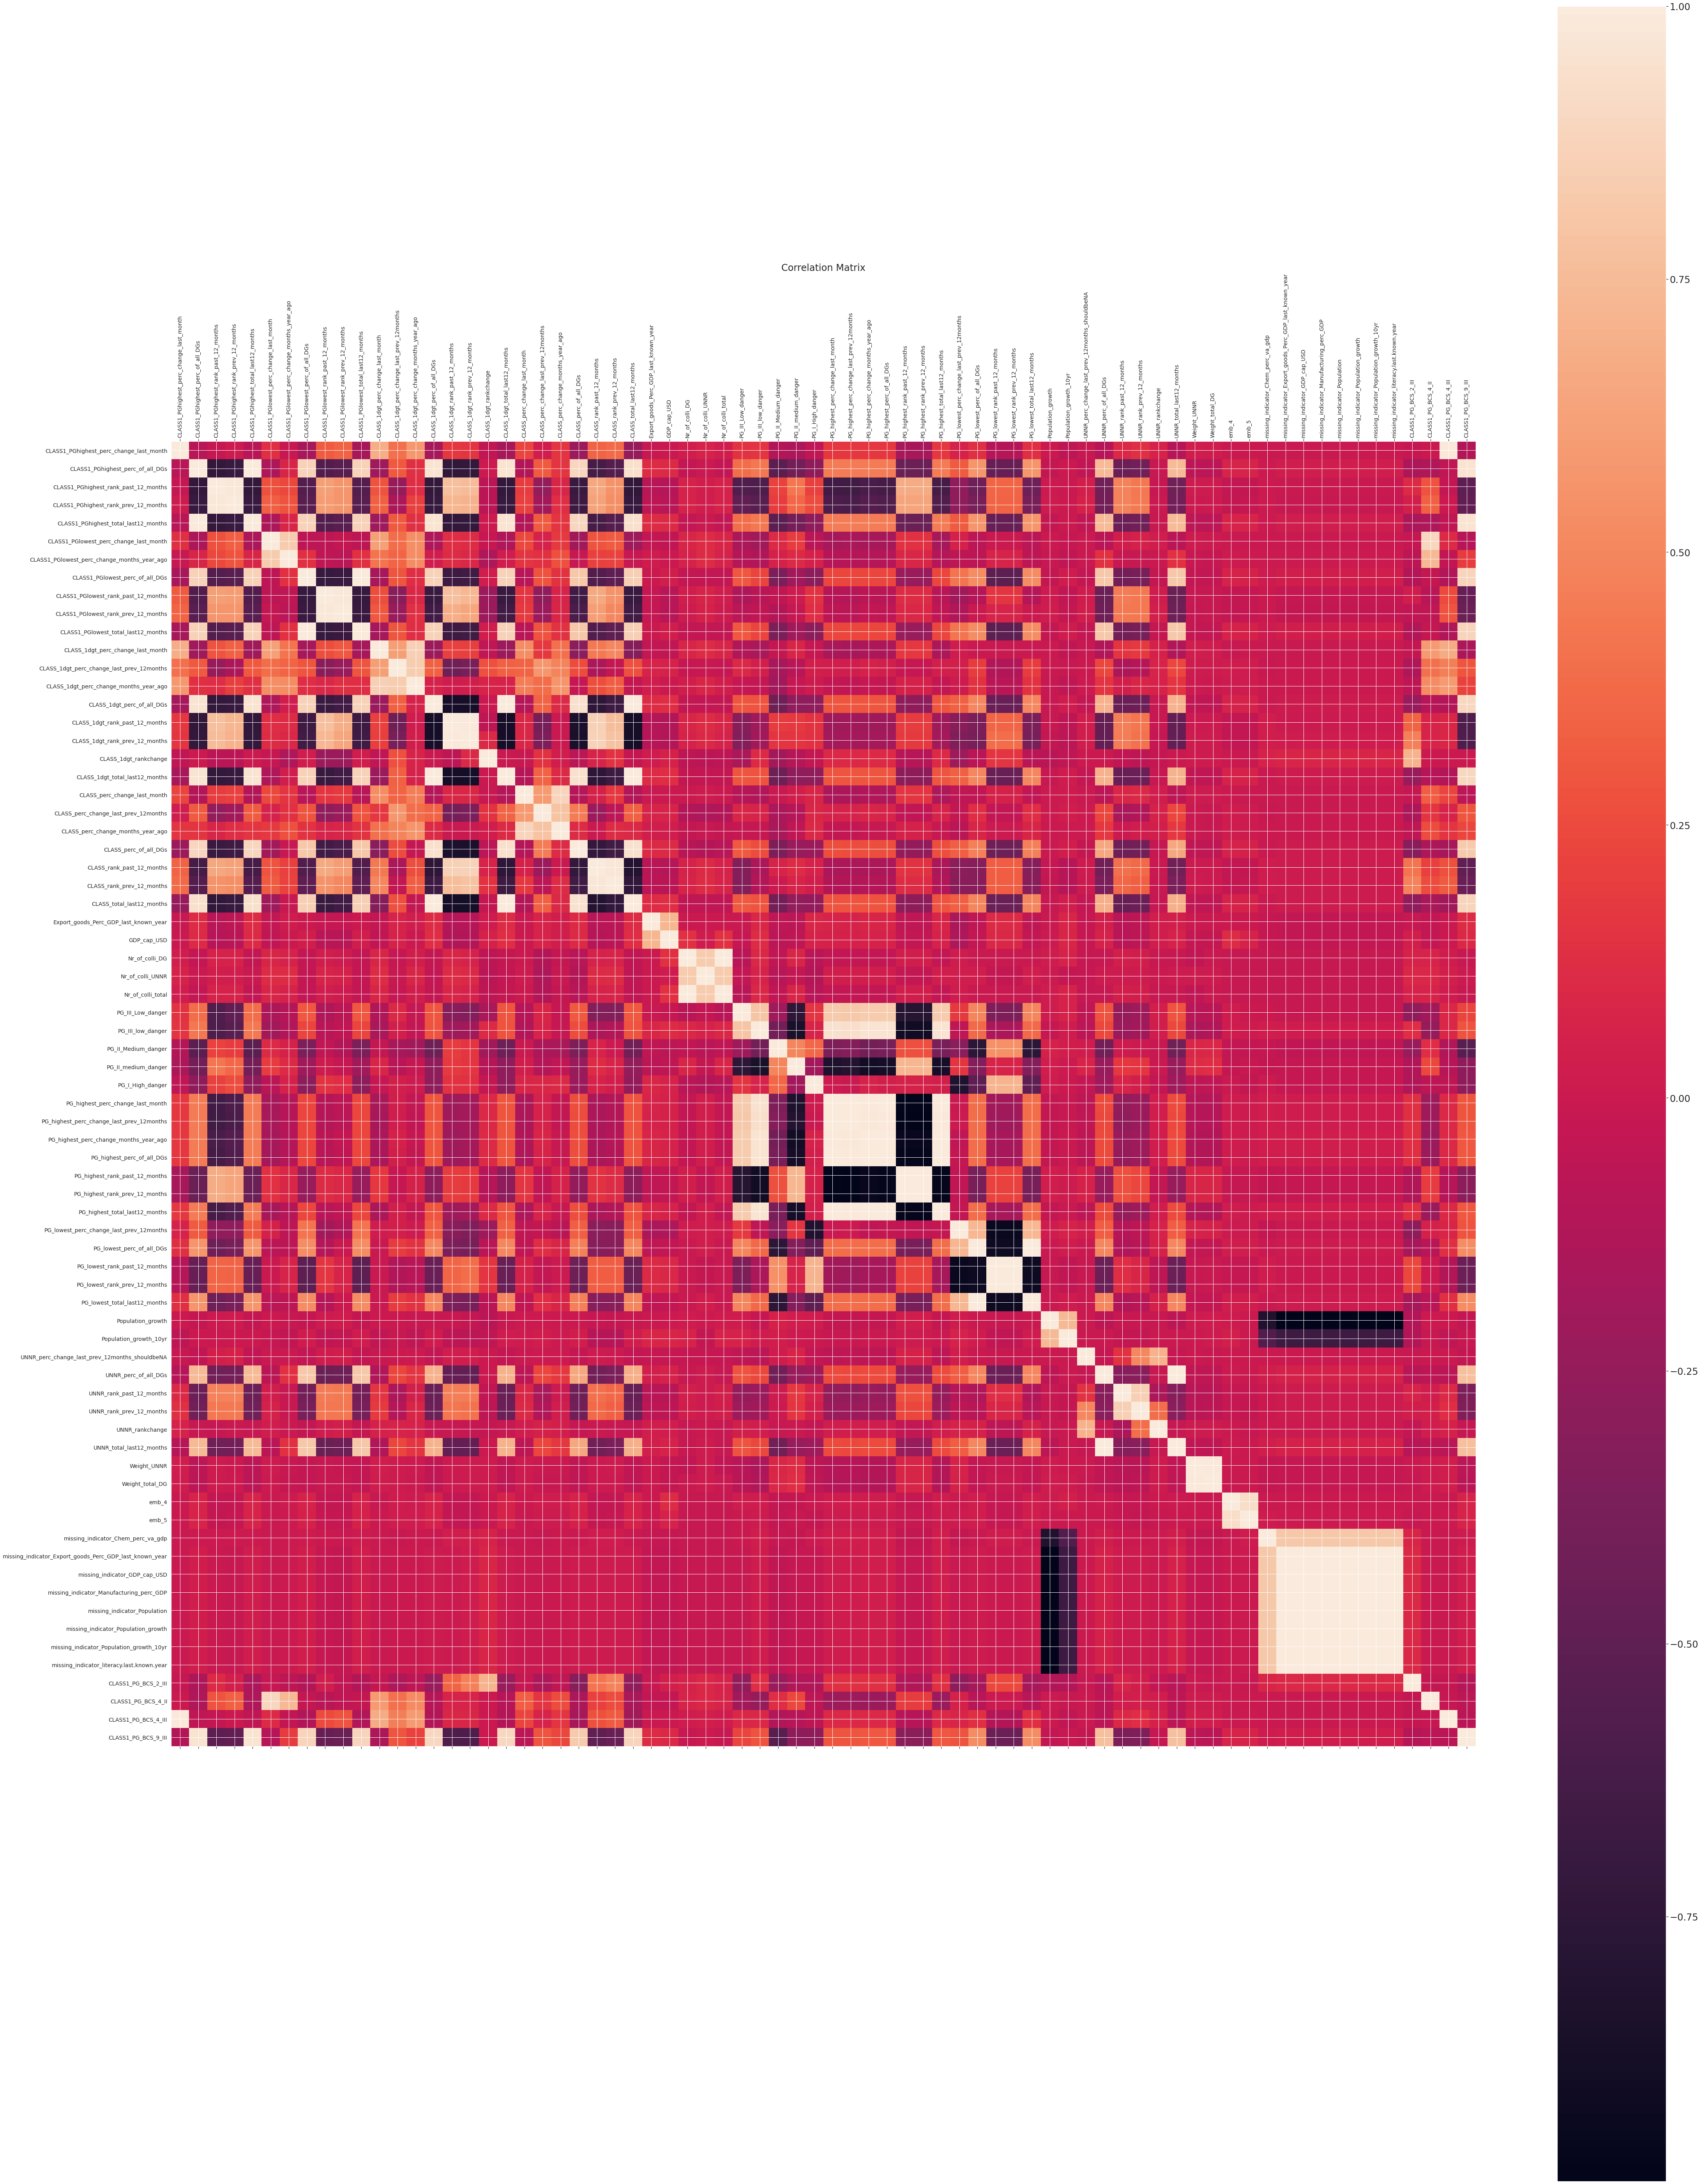

In [246]:
f = plt.figure(figsize=(75, 100))
plt.matshow(df_corr, fignum=f.number)
plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)
plt.title('Correlation Matrix', fontsize=24);

In [247]:
#columns that were removed
df_non_corr.columns.tolist()

['index',
 'target',
 'CLASS1_PGhighest_perc_change_last_month_shouldbeNA',
 'CLASS1_PGhighest_perc_change_last_prev_12months',
 'CLASS1_PGhighest_perc_change_last_prev_12months_shouldbeNA',
 'CLASS1_PGhighest_perc_change_months_year_ago',
 'CLASS1_PGhighest_perc_change_months_year_ago_shouldbeNA',
 'CLASS1_PGhighest_rankchange',
 'CLASS1_PGlowest_perc_change_last_month_shouldbeNA',
 'CLASS1_PGlowest_perc_change_last_prev_12months',
 'CLASS1_PGlowest_perc_change_last_prev_12months_shouldbeNA',
 'CLASS1_PGlowest_perc_change_months_year_ago_shouldbeNA',
 'CLASS1_PGlowest_rankchange',
 'CLASS_1dgt_perc_change_last_month_shouldbeNA',
 'CLASS_1dgt_perc_change_last_prev_12months_shouldbeNA',
 'CLASS_1dgt_perc_change_months_year_ago_shouldbeNA',
 'CLASS_perc_change_last_month_shouldbeNA',
 'CLASS_perc_change_last_prev_12months_shouldbeNA',
 'CLASS_perc_change_months_year_ago_shouldbeNA',
 'CLASS_rankchange',
 'Cargo_agent_is_assignee',
 'Chem_perc_va_gdp',
 'Country_last_harbour_is_country_or

In [304]:
#the first calibrated model, there are 10
np.size(model.calibrated_classifiers_[0].base_estimator.feature_importances_)

512

In [306]:
data.columns.tolist()

['container_time_id',
 'target',
 'CLASS1_PGhighest_perc_change_last_month',
 'CLASS1_PGhighest_perc_change_last_month_shouldbeNA',
 'CLASS1_PGhighest_perc_change_last_prev_12months',
 'CLASS1_PGhighest_perc_change_last_prev_12months_shouldbeNA',
 'CLASS1_PGhighest_perc_change_months_year_ago',
 'CLASS1_PGhighest_perc_change_months_year_ago_shouldbeNA',
 'CLASS1_PGhighest_perc_of_all_DGs',
 'CLASS1_PGhighest_rank_past_12_months',
 'CLASS1_PGhighest_rank_prev_12_months',
 'CLASS1_PGhighest_rankchange',
 'CLASS1_PGhighest_total_last12_months',
 'CLASS1_PGlowest_perc_change_last_month',
 'CLASS1_PGlowest_perc_change_last_month_shouldbeNA',
 'CLASS1_PGlowest_perc_change_last_prev_12months',
 'CLASS1_PGlowest_perc_change_last_prev_12months_shouldbeNA',
 'CLASS1_PGlowest_perc_change_months_year_ago',
 'CLASS1_PGlowest_perc_change_months_year_ago_shouldbeNA',
 'CLASS1_PGlowest_perc_of_all_DGs',
 'CLASS1_PGlowest_rank_past_12_months',
 'CLASS1_PGlowest_rank_prev_12_months',
 'CLASS1_PGlowest_r

In [299]:
#TODO:
#0. average faeture importance (permutation, SHAP, vanilla) 
#1. average rankchange diference per feature
#2. clustering of correlatation per feature importace per calibrated model
#3. SHAP feature interactions

<AxesSubplot:xlabel='feature'>

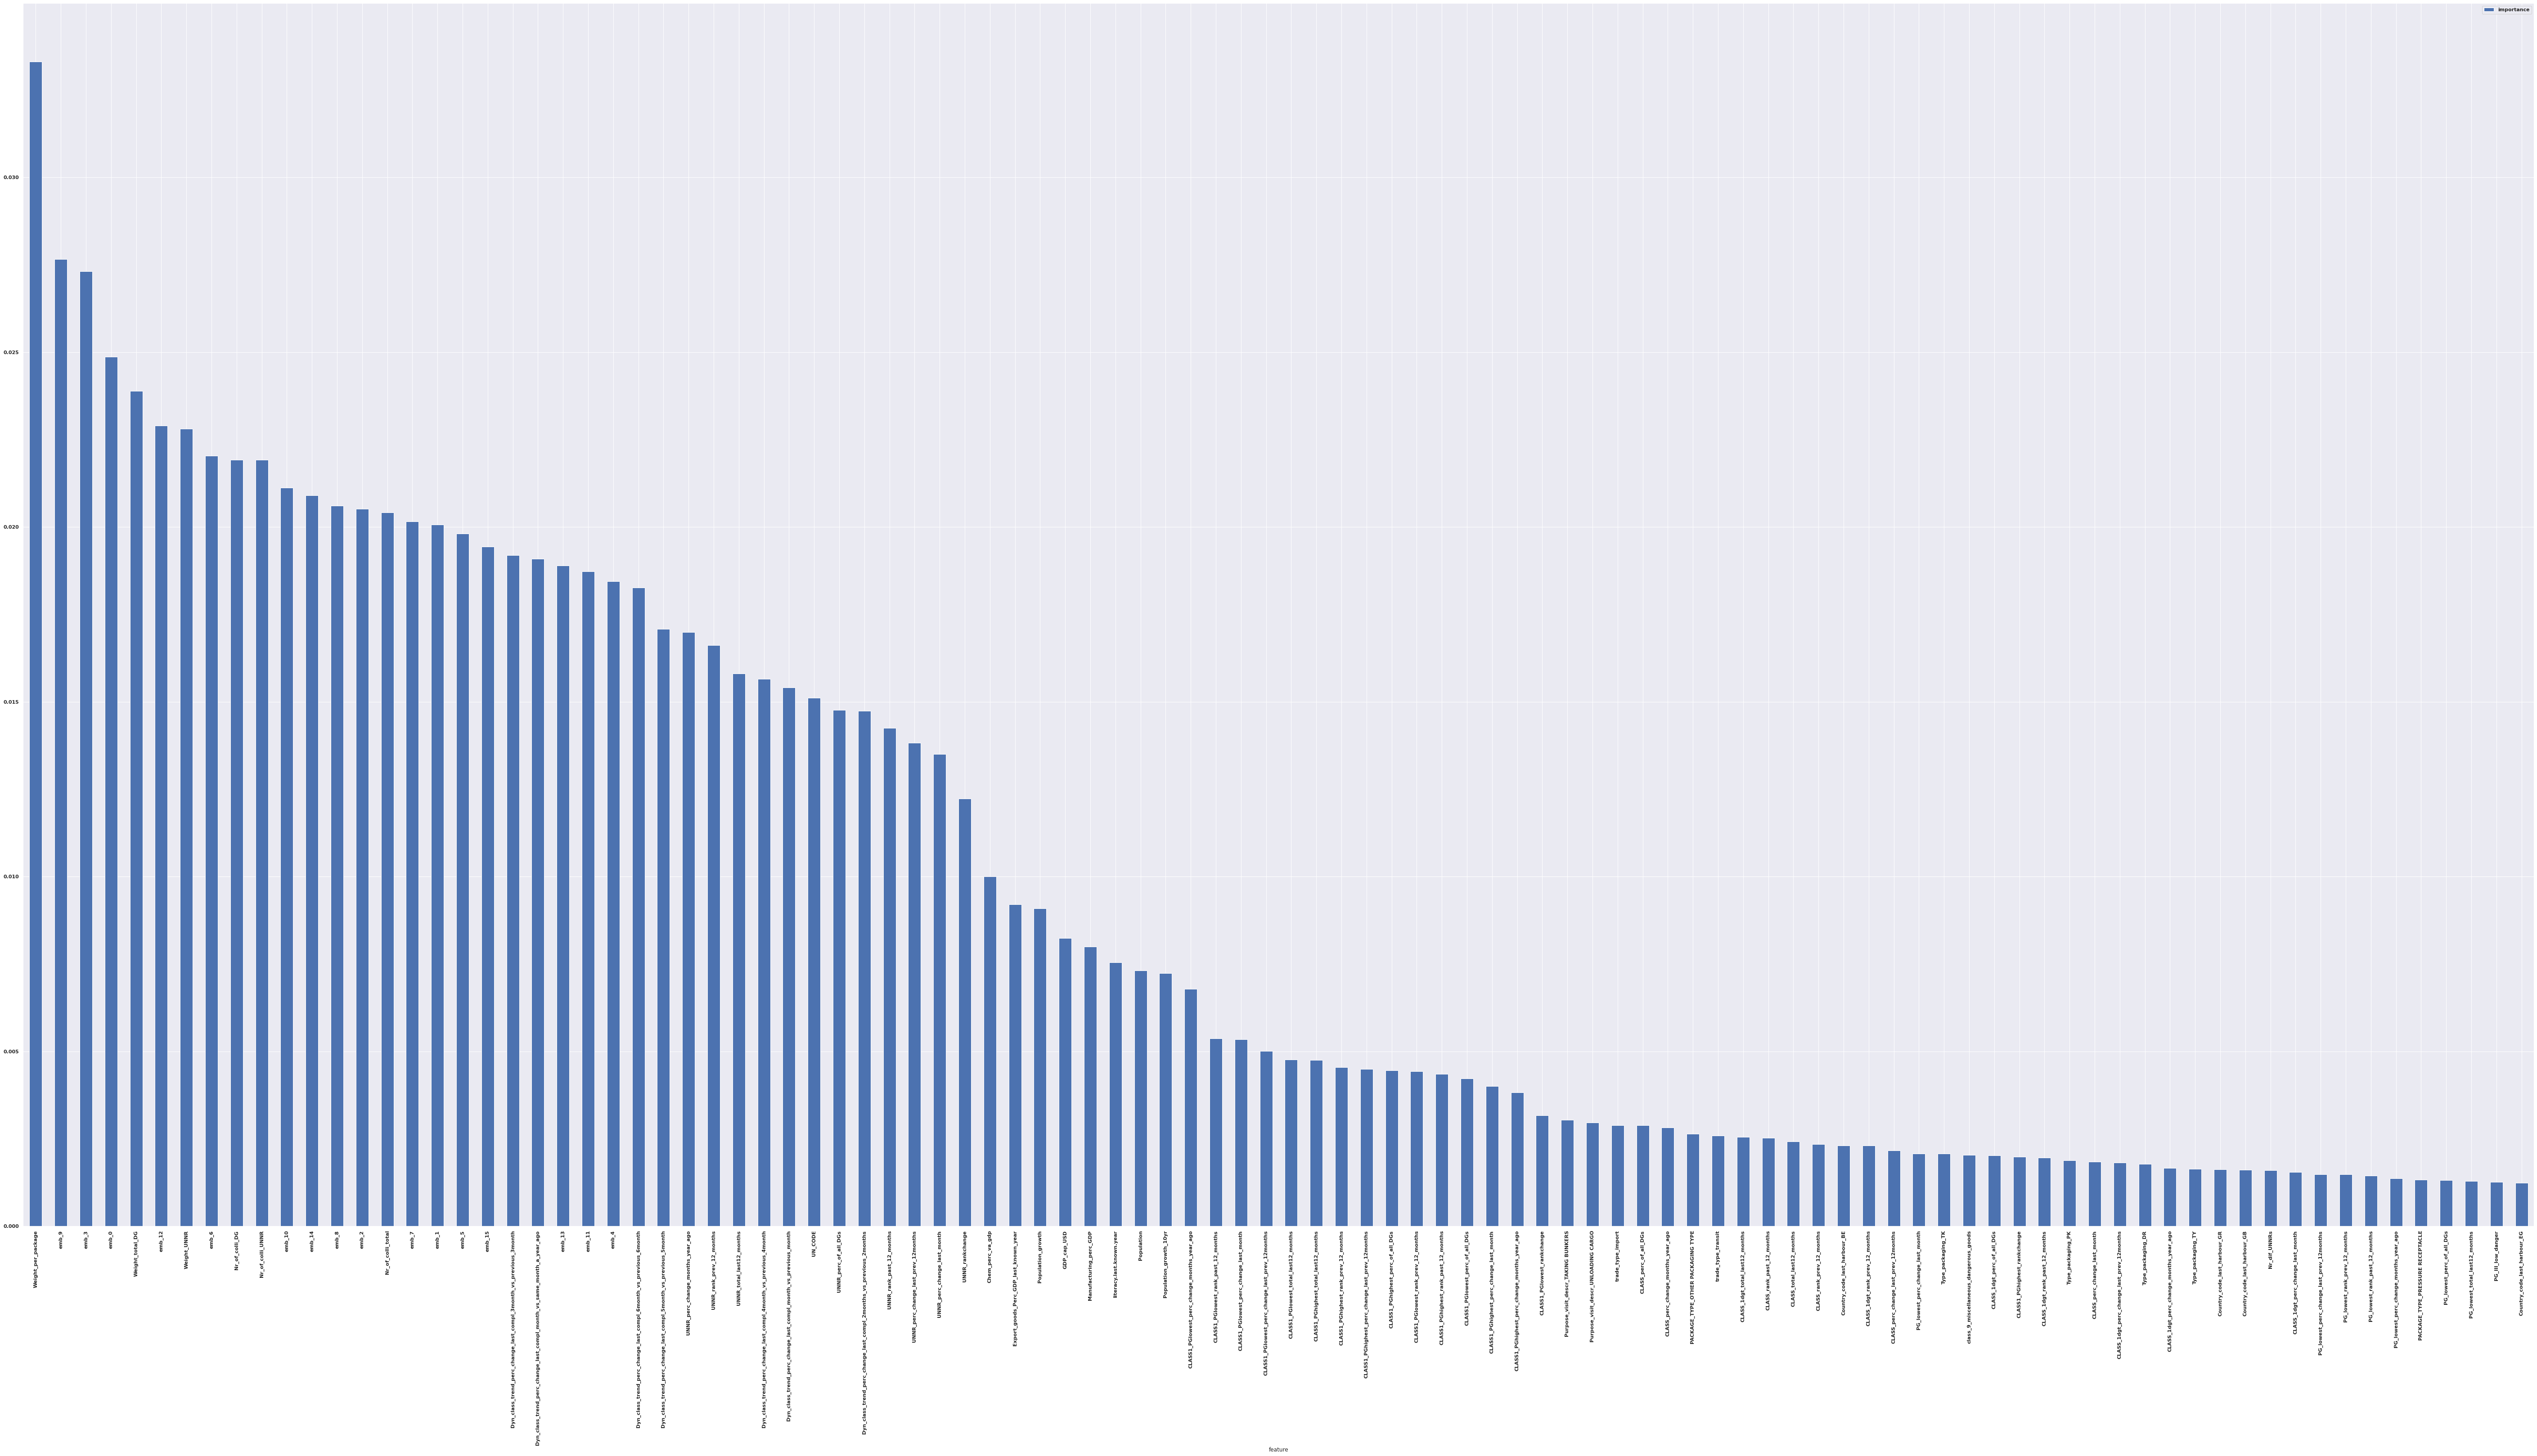

In [329]:
#model feature importance
#value importance is useful to understand where the rf makes the most splits


    
valueImp = pd.DataFrame({"feature": data.columns, "importance": model.calibrated_classifiers_[0].base_estimator.feature_importances_})
valueImp = valueImp.sort_values(['importance'], ascending=False)
valueImp.set_index('feature',inplace=True)
valueImp[0:100].plot(kind='bar')

fig = plt.gcf()
fig.set_size_inches(100, 50)

plt.rcParams.update({'font.size': 48})
plt.show()

In [330]:
valueImp

,importance
feature,
Weight_per_package,0.033319
emb_9,0.027669
emb_3,0.027311
emb_0,0.024868
Weight_total_DG,0.023896
...,...
Purpose_visit_descr_REPAIR,0.000000
Purpose_visit_descr_No purpose of visit reported,0.000000
Purpose_visit_descr_LOADING CARGO,0.000000


In [335]:
calibrated_valueImp = pd.DataFrame({"feature": data.columns, "importance_0": model.calibrated_classifiers_[0].base_estimator.feature_importances_})
i=1
for calibrated_model in model.calibrated_classifiers_[1:]:
    
    calibrated_valueImp['importance_'+str(i)]=  calibrated_model.base_estimator.feature_importances_
    i=i+1
    
#calibrated_valueImp.to_csv('../data/calibrated_featureImp.csv',index=False)

In [339]:
calibrated_valueImp['mean'] = calibrated_valueImp.mean(axis=1)
calibrated_valueImp = calibrated_valueImp.sort_values(by='mean',ascending=False).index()

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance_5,importance_6,importance_7,importance_8,importance_9,mean
107,Weight_per_package,0.033319,0.030266,0.030898,0.032376,0.032423,0.031983,0.030136,0.031004,0.033465,0.032892,0.031876
138,emb_9,0.027669,0.030430,0.028536,0.027947,0.026374,0.028781,0.028227,0.027545,0.026962,0.026257,0.027873
132,emb_3,0.027311,0.029168,0.027992,0.025574,0.026691,0.025164,0.025786,0.024754,0.026571,0.024728,0.026374
106,Weight_UNNR,0.022811,0.021701,0.024765,0.024826,0.027187,0.021416,0.021384,0.021768,0.024012,0.022354,0.023222
123,emb_0,0.024868,0.021622,0.020790,0.021158,0.022981,0.022238,0.024193,0.025668,0.023497,0.024337,0.023135
...,...,...,...,...,...,...,...,...,...,...,...,...
303,Type_packaging_4H,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
302,Type_packaging_4G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
301,Type_packaging_4F,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
300,Type_packaging_4D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
#SHAP

#Boxplot of feature importances 
#clustering features with importances
#interaction values

In [428]:
#boxplot of feature importances
import tqdm

#making a DF with global (Average) SHAP feature importances for each calibrated estimator
#using ABSOLUTE SHAP vals from class 1 only
explainer = shap.Explainer(model.calibrated_classifiers_[0].base_estimator)
shap_values = explainer(data).values
calibrated_valueImp_SHAP = pd.DataFrame({"feature": data.columns, "importance_0": shap_values[:,:,1].mean(axis=0)})


i=1
for calibrated_model in model.calibrated_classifiers_[1:]:
    
    explainer = shap.Explainer(model.calibrated_classifiers_[i].base_estimator)
    shap_values = explainer(data).values
    calibrated_valueImp_SHAP['importance_'+str(i)] = abs(shap_values[:,:,1]).mean(axis=0)
    i=i+1

calibrated_valueImp_SHAP.to_csv('../data/calibrated_featureImp_SHAP.csv',index=False)

KeyboardInterrupt: 

In [445]:
calibrated_valueImp_SHAP= pd.read_csv('../data/calibrated_featureImp_SHAP.csv')

In [446]:
#sorting by mean and transposing for the boxplot
calibrated_valueImp_SHAP['mean'] = calibrated_valueImp_SHAP.mean(axis=1)
calibrated_valueImp_SHAP = calibrated_valueImp_SHAP.sort_values(by='mean',ascending=False)
calibrated_valueImp_SHAP = calibrated_valueImp_SHAP.drop('mean',axis=1)
calibrated_valueImp_SHAP = calibrated_valueImp_SHAP.set_index('feature',drop=True)
calibrated_valueImp_SHAP = calibrated_valueImp_SHAP.T
calibrated_valueImp_SHAP.head()

feature,Weight_per_package,Nr_of_colli_DG,Nr_of_colli_UNNR,Nr_of_colli_total,emb_9,emb_3,Weight_UNNR,Weight_total_DG,Dyn_class_trend_perc_change_last_compl_month_vs_same_month_a_year_ago,emb_10,...,Type_packaging_1D,Purpose_visit_descr_LAID-UP,Type_packaging_-1,CLASS1_PGhighest_perc_change_last_prev_12months_shouldbeNA,Purpose_visit_descr_TR.CUSTOMS CLEARANCE,Purpose_visit_descr_TAKING SUPPLIES,CLASS1_PGhighest_perc_change_months_year_ago_shouldbeNA,Purpose_visit_descr_REPAIR,Purpose_visit_descr_No purpose of visit reported,Country_code_last_harbour_TR
importance_0,-0.000325,0.000132,-0.000215,0.000334,-0.000061,0.000156,-0.000472,-0.000944,-0.000110,0.000027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
importance_1,0.018063,0.014758,0.016421,0.014054,0.013623,0.015024,0.006840,0.007413,0.006484,0.007352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
importance_2,0.018840,0.014539,0.014264,0.016278,0.011484,0.014112,0.009592,0.005882,0.007173,0.004945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
importance_3,0.017988,0.016676,0.012587,0.014989,0.013794,0.012301,0.011299,0.007594,0.007412,0.008479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
importance_4,0.018532,0.016434,0.014946,0.015653,0.011121,0.012523,0.011486,0.011681,0.007340,0.006422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [447]:
calibrated_valueImp_SHAP.mean(axis=0)

feature
Weight_per_package                                         0.016404
Nr_of_colli_DG                                             0.013907
Nr_of_colli_UNNR                                           0.013794
Nr_of_colli_total                                          0.013254
emb_9                                                      0.011174
                                                             ...   
Purpose_visit_descr_TAKING SUPPLIES                        0.000000
CLASS1_PGhighest_perc_change_months_year_ago_shouldbeNA    0.000000
Purpose_visit_descr_REPAIR                                 0.000000
Purpose_visit_descr_No purpose of visit reported           0.000000
Country_code_last_harbour_TR                               0.000000
Length: 512, dtype: float64

In [454]:
#how many features have feat_imp 0?
512 - (calibrated_valueImp_SHAP.mean(axis=0)>0).sum()

308

In [464]:
#which are those features that have a feature importance 0?
sorted((calibrated_valueImp_SHAP.mean(axis=0)[(calibrated_valueImp_SHAP.mean(axis=0)<0.00001)]).index.tolist())

['CLASS1_PG_BCS_1_III',
 'CLASS1_PG_BCS_2_II',
 'CLASS1_PG_BCS_4_I',
 'CLASS1_PG_BCS_5_I',
 'CLASS1_PG_BCS_7_III',
 'CLASS1_PG_BCS_8_I',
 'CLASS1_PG_BCS_9_II',
 'CLASS1_PG_WCS_1_I',
 'CLASS1_PG_WCS_2_II',
 'CLASS1_PG_WCS_2_III',
 'CLASS1_PG_WCS_5_I',
 'CLASS1_PG_WCS_5_III',
 'CLASS1_PG_WCS_7_I',
 'CLASS1_PG_WCS_9_II',
 'CLASS1_PGhighest_perc_change_last_month_shouldbeNA',
 'CLASS1_PGhighest_perc_change_last_prev_12months_shouldbeNA',
 'CLASS1_PGhighest_perc_change_months_year_ago_shouldbeNA',
 'CLASS1_PGlowest_perc_change_last_month_shouldbeNA',
 'CLASS1_PGlowest_perc_change_last_prev_12months_shouldbeNA',
 'CLASS1_PGlowest_perc_change_months_year_ago_shouldbeNA',
 'CLASS_1dgt_perc_change_last_month_shouldbeNA',
 'CLASS_1dgt_perc_change_last_prev_12months_shouldbeNA',
 'CLASS_1dgt_perc_change_months_year_ago_shouldbeNA',
 'CLASS_perc_change_last_month_shouldbeNA',
 'CLASS_perc_change_last_prev_12months_shouldbeNA',
 'CLASS_perc_change_months_year_ago_shouldbeNA',
 'Country_code_last_ha

<AxesSubplot:>

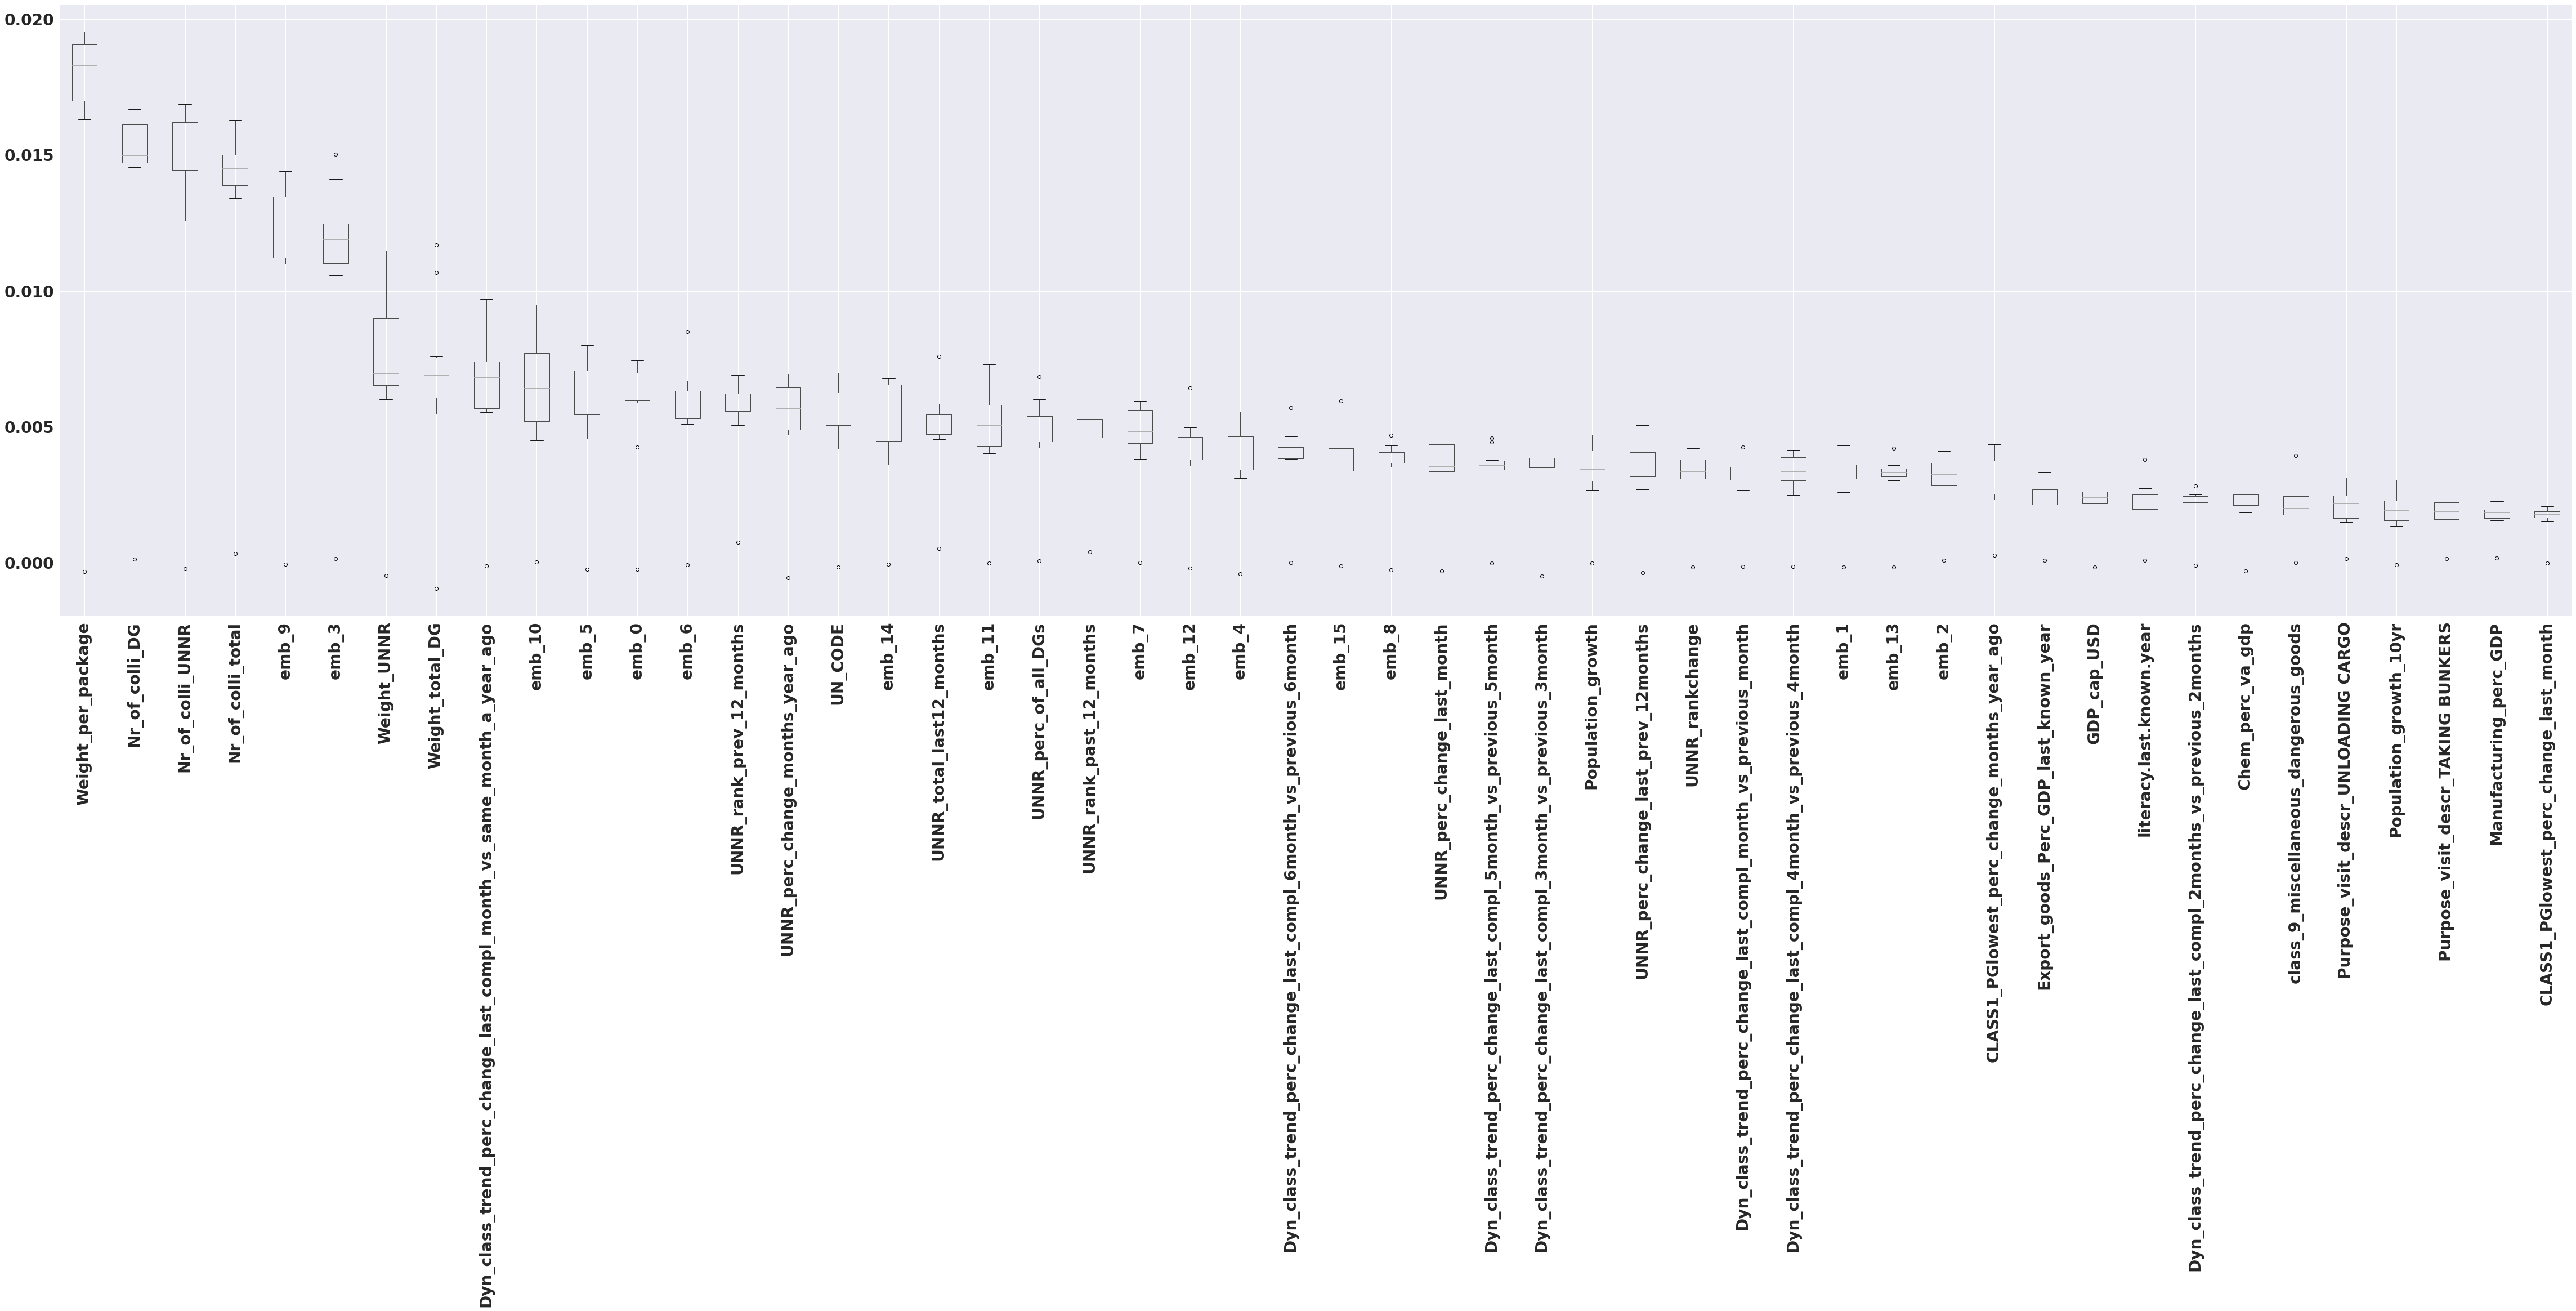

In [450]:
calibrated_valueImp_SHAP[calibrated_valueImp_SHAP.columns.tolist()[0:50]].boxplot(fontsize=28,figsize=(80,20),rot=90)

In [ ]:
clustering = shap.utils.hclust(X, y) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_values, clustering=clustering)

In [ ]:
# clust = shap.utils.hclust(X, y, linkage="single")
# shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [542]:
#get the indices of each of the subsets used as test set AICI
dir(model.calibrated_classifiers_[0].base_estimator.base_estimator)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_X_predict',
 '_validate_data',
 'apply',
 'ccp_alpha',
 'class_weight',
 'cost_complexity_pruning_path',
 'criterion',
 'decision_path',
 'feature_importances_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fracti

In [470]:
import time
now=time.time()
result = permutation_importance(
    model.calibrated_classifiers_[0].base_estimator, X, y, n_repeats=3, random_state=42, n_jobs=8)
print('Took', time.time()-now,'seconds')

calibrated_valueImp_perm=pd.DataFrame(columns='importance_0',result.importances_mean)

AttributeError: module 'time' has no attribute 'now'

In [489]:
calibrated_valueImp_perm=pd.DataFrame(result.importances_mean)
calibrated_valueImp_perm.columns=['importance_0']
calibrated_valueImp_perm.index = X.columns
calibrated_valueImp_perm = calibrated_valueImp_perm.sort_values(by='importance_0',ascending=False)

In [490]:
calibrated_valueImp_perm

,importance_0
emb_3,0.017320
Weight_per_package,0.014379
emb_9,0.013072
Nr_of_colli_DG,0.012418
Weight_total_DG,0.012092
...,...
Country_code_last_harbour_IS,0.000000
Country_code_last_harbour_IN,0.000000
Country_code_last_harbour_IE,0.000000
Country_code_last_harbour_GI,0.000000


In [ ]:
#permutation feature importance
#In this example, we will compare the impurity-based feature importance of RandomForestClassifier with the permutation importance on the titanic dataset using permutation_importance. We will show that the impurity-based feature importance can inflate the importance of numerical features.
#Furthermore, the impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.
#This example shows how to use Permutation Importances as an alternative that can mitigate those limitations.
from sklearn.inspection import permutation_importance

i=1
for calibrated_model in model.calibrated_classifiers_[1:]:

    result = permutation_importance(model.calibrated_classifiers_[i].base_estimator, X, y, n_repeats=10, random_state=42, n_jobs=8)
    calibrated_valueImp_perm['importance_'+str(i)] = result
    i=i+1


ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()